# Download and Import Packages

In [ ]:
!pip install keras_tuner

In [ ]:
import numpy as np
import itertools
import random
import math 
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from typing import Sequence, Iterator, Iterable, Tuple, List
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, display

## Downloading the Dataset:

In [15]:
import kagglehub

path = kagglehub.dataset_download("khlaifiabilel/military-aircraft-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.13G/1.13G [00:14<00:00, 82.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khlaifiabilel/military-aircraft-recognition-dataset/versions/1


# Load and Read the Data:

### Annotation Data Structure:
Defining a class to hold a single object's annotation details.

In [ ]:
@dataclass(frozen=True, slots=True)
class Annotation:
    label: str
    xmin: int
    ymin: int
    xmax: int
    ymax: int

### Sample Data Structure:
Defining a class to hold one full data sample (an image and all its annotations).

In [16]:
@dataclass(frozen=True, slots=True)
class Sample:
    image: Image.Image
    annotations: Sequence[Annotation]

### XML Parsing Utilities (Pascal VOC):
Reads a Pascal VOC XML annotation file and returns an iterator of Annotation objects. The use of an iterator (yield) makes this memory-efficient.


In [17]:
import xml.etree.ElementTree as ET

def iter_annotations(xml_path: str) -> Iterator[Annotation]:
    """
    Stream Pascal VOC annotations from an XML file.
    Memory-efficient and scalable.
    """

    for _, elem in ET.iterparse(xml_path, events=("end",)):
        if elem.tag != "object":
            continue

        try:
            name = elem.findtext("name")
            box = elem.find("bndbox")

            xmin = int(box.findtext("xmin"))
            ymin = int(box.findtext("ymin"))
            xmax = int(box.findtext("xmax"))
            ymax = int(box.findtext("ymax"))

            yield Annotation(name, xmin, ymin, xmax, ymax)

        # Clears the element and its children from memory immediately after processing.
        finally:
            elem.clear()


def read_annotations(xml_path: str) -> list[Annotation]:
  """
    A utility function that calls {iter_annotations} and converts the iterator into a complete list of Annotation objects, loading all annotations from one XML file into memory.
  """
  return list(iter_annotations(xml_path))

Check if an image is in the standard 3-channel **RGB format**:

In [ ]:
def is_rgb(img: Image.Image) -> bool:
    return img.mode == "RGB"

### Dataset Iterator

Iterating over a list of file names, loading the corresponding image and XML file, and yielding a Sample. The use of Iterator ensures lazy loading (only one sample is loaded into memory at a time).

In [ ]:
def iter_data(
    file_names: Iterable[str],
    root_dir: Path,
) -> Iterator[Sample]:
    """
    Lazily iterate over images and their annotations.
    Memory-efficient and consistent with iter_annotations.
    """

    jpeg_dir = root_dir / "JPEGImages"
    xml_dir = root_dir / "Annotations" / "Horizontal Bounding Boxes"

    for name in file_names:
        img_path = jpeg_dir / f"{name}.jpg"
        xml_path = xml_dir / f"{name}.xml"

        if not img_path.exists() or not xml_path.exists():
            continue

        try:
            with Image.open(img_path) as img:
                if not is_rgb(img):
                    continue

                annotations = list(iter_annotations(xml_path))
                if not annotations:
                    continue

                # copy() decouples from the file handle
                yield Sample(img.copy(), annotations)

        except Exception:
            # corrupted image or XML → skip safely
            continue

### Dimension Collection and Eager Loading
Calculating the width and height of every single bounding box across the entire dataset.

In [18]:
def collect_object_dims(samples: Iterable[Sample]) -> list[int]:
    dims: list[int] = []

    for sample in samples:
        for ann in sample.annotations:
            dims.append(abs(ann.xmax - ann.xmin))
            dims.append(abs(ann.ymax - ann.ymin))

    return dims

The main entry point to load the entire dataset partition (e.g., training set) into memory (eager loading).

In [ ]:
def read_data(
    file_names: Iterable[str],
    data_dir: str,
):
    """
    Eagerly load dataset into memory.
    Returns:
        data: list[Sample]
        dims: list[int]
    """

    root = Path(data_dir)

    samples = list(iter_data(file_names, root))
    dims = collect_object_dims(samples)

    return samples, dims

### Visualization

Taking a Sample object and generates a new image with the bounding boxes and labels drawn on it. Creating a copy of the image so that the operations do not modify the original image data stored in the Sample object.Then, Creating a drawing context object tied to the copied image.

In [20]:
def visualize_sample(sample: Sample) -> Image.Image:
    """
    Draw bounding boxes and labels on a copy of the image.
    Returns a new PIL Image object.
    """
    img = sample.image.copy()
    draw = ImageDraw.Draw(img)

    # Drawing a red rectangle around the object using its coordinates.
    for ann in sample.annotations:
        draw.rectangle([ann.xmin, ann.ymin, ann.xmax, ann.ymax], outline="red", width=2)
        draw.text((ann.xmin, ann.ymin), ann.label, fill="red")

    return img

### Split Loading




Loading the list of base file names for a given dataset split (e.g., 'train', 'val', 'test') from the standard Pascal VOC ImageSets directory structure.

In [21]:
def load_split_filenames(root_dir: str, split: str) -> list[str]:
    """
    Load filenames for a given split ('train', 'test', etc.).
    """
    split_file = Path(root_dir) / "ImageSets" / "Main" / f"{split}.txt"

    if not split_file.exists():
        raise FileNotFoundError(f"Split file not found: {split_file}")

    return split_file.read_text().splitlines()

In [22]:
# Setting a variable for the root directory of the downloaded dataset.
DATA_DIR = path

# Load train filenames and loading the dataset
train_filenames = load_split_filenames(DATA_DIR, "train")
train_data, train_obj_dims = read_data(train_filenames, DATA_DIR)

# Display first sample
example_img = visualize_sample(train_data[0])
example_img

# Preprocessing:

### Aspect-Ratio Preserving Resize:

We need the images to be of the **same size**. Since we are going to extract objects from each image, they will not be of the same size as the annotations do not cover the same area, i.e., some form a smaller rectangle with dimensions (24, 24), and some bigger ones like (111, 140). Therefore, they need to be transformed in a way that they are of equal dimensions. Having said that, we also need to make sure the ratio of images don’t change. The easiest way to do so, is to create a squared empty image and paste the object onto the center of it, of which the function below takes care.
<br>
<br> **The Math Behind the Transformation:**
<br> When we pad the image, we shift the pixels by an offset $(pad_x, pad_y)$. When we resize, we scale by a factor $s$. The new coordinates $(x', y')$ are calculated as:
<br>
<br>
$$x' = (x_{old} + pad_x) \cdot \frac{Width_{target}}{max(Width_{old}, Height_{old})}$$$$y' = (y_{old} + pad_y) \cdot \frac{Height_{target}}{max(Width_{old}, Height_{old})}$$

In [23]:
def pad_and_resize_image(img: Image.Image, target_size: Tuple[int, int] = (64, 64)) -> Image.Image:
    old_w, old_h = img.size
    new_w, new_h = target_size

    # Calculate padding to make the image square
    max_dim = max(old_w, old_h)
    pad_x = (max_dim - old_w) // 2
    pad_y = (max_dim - old_h) // 2

    # Create a new square canvas and paste the image
    canvas = Image.new("RGB", (max_dim, max_dim), (0, 0, 0)) # Black padding
    canvas.paste(img, (pad_x, pad_y))

    # Resize to target_size
    resized_img = canvas.resize(target_size, Image.Resampling.LANCZOS)
    return resized_img


### Object Extraction & Normalization:
This function is a pivotal bridge in your pipeline. It effectively converts an Object Detection task into an **Image Classification Task** by "cutting out" the aircraft from the large original images and treating each crop as a standalone training example.
<br>
<br>This module is responsible for generating the final training inputs for the CNN. It transitions the data from "Scene-level" (large images with multiple planes) to "Object-level" (individual images of one plane).

In [24]:
def extract_and_process_objects(sample: Sample, target_size: Tuple[int, int] = (64, 64)) -> Tuple[List[Image.Image], np.ndarray]:
    """
    Extracts each annotated object from the sample image, pads it to a square,
    and resizes it to target_size.
    """
    crops = []
    labels = []

    for ann in sample.annotations:
        #  Define the crop box (left, top, right, bottom)
        box = (ann.xmin, ann.ymin, ann.xmax, ann.ymax)

        #  Extract the raw crop
        raw_crop = sample.image.crop(box)

        #  Apply the padding/resizing logic using the new helper function
        processed_crop = pad_and_resize_image(raw_crop, target_size)

        crops.append(processed_crop)
        labels.append(ann.label)

    return crops, np.array(labels)


### Preprocessing Pipeline:
The ```preprocessing``` function acts as the terminal stage of the data engineering pipeline. It transforms high-level Sample objects into ***numerical tensors*** ready for consumption.

In [ ]:
def preprocessing(data_list: list[Sample], target_size: tuple[int, int] = (64, 64)):
    """
    Main pipeline: Extracts, pads, normalizes images, and one-hot encodes labels.
    Returns:
        X: (N, H, W, 3) normalized image array
        y: (N, Num_Classes) one-hot encoded labels
        encoder: The fitted OneHotEncoder for later inference
    """
    all_processed_images = []
    all_labels = []

    # Extraction and Normalization in a single pass
    for sample in data_list:
        # Reusing the optimized extraction from the previous step
        crops, labels = extract_and_process_objects(sample, target_size)

        for crop in crops:
            # Convert to numpy and normalize to [0, 1] immediately
            img_array = np.array(crop, dtype=np.float32) / 255.0
            all_processed_images.append(img_array)

        all_labels.extend(labels)

    # Convert to final 4D Numpy Array (N, 64, 64, 3)
    X = np.stack(all_processed_images)

    # Categorical Encoding
    label_array = np.array(all_labels).reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(label_array)

    return X, y, encoder


### Run the Preprocessing Pipeline

In [ ]:
# X: Images, y: One-hot labels, encoder: The object that knows the class names
X, y, encoder = preprocessing(train_data)
n_labels = y.shape[1]

print(f"Dataset processed. Total images: {X.shape[0]}")
print(f"Number of classes detected: {n_labels}")

# Get original class names for titles
# We use the encoder to transform the numerical y back to text for display
class_names = encoder.categories_[0]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
indices = [
    np.argmin(train_obj_dims) // 2,  # Index of smallest object
    30,                              # A random sample
    np.argmax(train_obj_dims) // 2   # Index of largest object
]
titles = ["Smallest Object", "Sample #30", "Largest Object"]

for i, ax in enumerate(axes):
    idx = indices[i]
    ax.imshow(X[idx])

    # Get the label name:
    label_idx = np.argmax(y[idx])
    label_name = class_names[label_idx]

    ax.set_title(f"{titles[i]}\nClass: {label_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Data Partitioning Strategy:
The final step of the preprocessing pipeline is the division of data into training and testing subsets.


*   **Test Size (33%)**: A standard ratio that provides enough data for the model to learn ($2/3$) while keeping a significant amount ($1/3$) for a statistically valid evaluation.
*   **Stratification**: By aligning the split with the label distribution, we ensure that the model is tested on every aircraft category, even the ones with fewer samples.



In [25]:
try:
    from colorama import Fore, Back, Style, init
    init(autoreset=True)
except ImportError:
    ! pip install colorama
    from colorama import Fore, Back, Style, init
    init(autoreset=True)
    class MockColor:
        def __getattr__(self, name): return ""
    Fore = Back = Style = MockColor()

# Perform the Split
# using 33% for testing, 67% for training.
# random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42,
    stratify=y # Added 'stratify' to ensure balanced classes in both sets
)

# Shape Verification with clean formatting
print(f"{Fore.YELLOW}Pipeline Complete: Data Split Results")
print("-" * 35)
print(f"{Fore.CYAN}Training Features: {Style.BRIGHT}{X_train.shape}")
print(f"{Fore.CYAN}Training Labels:   {Style.BRIGHT}{y_train.shape}")
print(f"{Fore.MAGENTA}Testing Features:  {Style.BRIGHT}{X_test.shape}")
print(f"{Fore.MAGENTA}Testing Labels:    {Style.BRIGHT}{y_test.shape}")
print("-" * 35)

# Model:

### Define Model:

**CNN Hyper-parameter Tuning:**
<br>

Instead of manual trial-and-error, we utilize the **Hyperband algorithm**.



1.   **Exploration**: The tuner starts by training dozens of different model architectures (different filter sizes, layer depths, and learning rates) for only a few epochs.
2.   **Exploitation**: It identifies the "top performers" based on ```val_accuracy```.
3. **Successive Halving**: The bottom-performing models are discarded, and the top models are given more epochs and resources to continue training.
4. **Final Selection**: The result is the single best architecture optimized for the specific aircraft features in dataset.



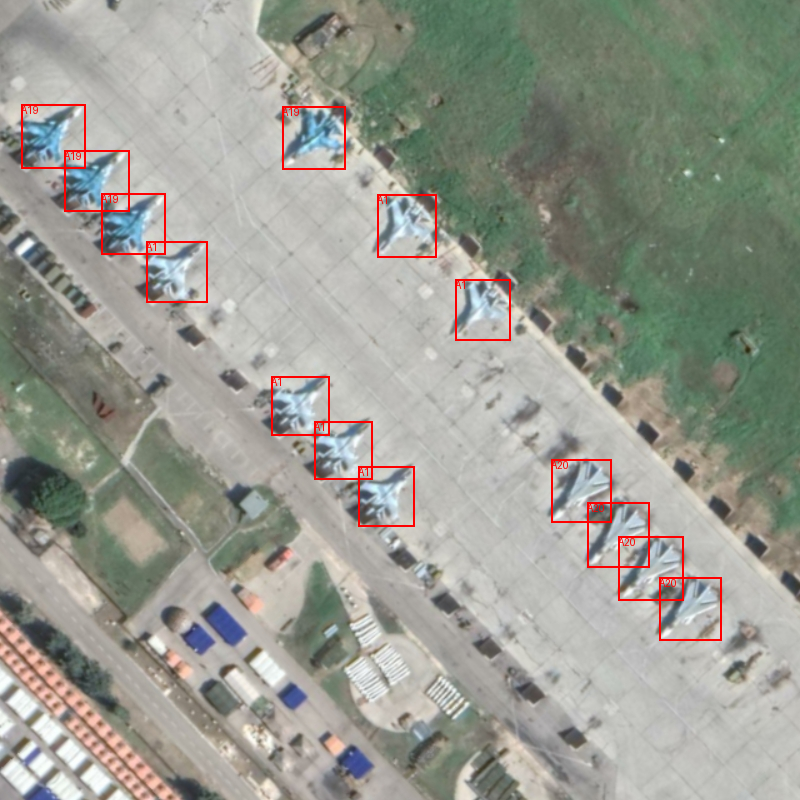

In [28]:
def build_model(hp):
    """
    Defines a Search Space for the CNN.
    The tuner will try different filters, dropout rates, and learning rates.
    """
    model = tf.keras.Sequential()

    # Input Layer:
    model.add(layers.Input(shape=(64, 64, 3)))

    # Tune the number of Convolutional Layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(layers.Flatten())

    # Tune the number of units in the Dense layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Output Layer (n_labels from our preprocessing)
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Initialize the Tuner:
Train and Test the model on Unseen Data.

In [29]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3, # Standard for Hyperband
    directory='tuning_results',
    project_name='aircraft_recognition',
    overwrite=True
)

# Start searching
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Cloning into 'Aircraft-Recognition-Pipeline'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


### Define the Model with Best Parameters:
Using the ```best_hps``` derived from the tuner (```conv_layers=1```, ```filters_0=128```, ```dropout_0=0.4```, ```dense_units=192```, ```learning_rate=0.001```), define the model architecture. Then, train this model using the prepared training and validation datasets (X_train, y_train, X_test, y_test) with early stopping. The trained model will be saved, and the training history will be recorded.

In [ ]:
# Manually define best_hps based on the Tuner Results
class ManualHyperParameters(kt.HyperParameters):
    def __init__(self):
        super().__init__()
        self.values = {
            'conv_layers': 1,
            'filters_0': 128,
            'dropout_0': 0.4,
            'dense_units': 192,
            'learning_rate': 0.001
        }

best_hps = ManualHyperParameters()

print(f"{Fore.GREEN}Best Hyperparameters Used (Manual):")
for param, value in best_hps.values.items():
    print(f" - {param}: {value}")

### Train the model with Best Hyper-Parameters:
This ensures the model is trained to its full potential using the most efficient architecture discovered.
<br>
<br>
By utilizing the **EarlyStopping callback**, we monitor the validation loss. If the model begins to "memorize" the training data (loss decreases) but stops improving on the test data (validation loss plateaus or increases), the training is terminated automatically.

In [ ]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps)

# Define an EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Final Training
print(f"\n{Fore.CYAN}Starting Final Model Training...")
history = model.fit(
    X_train,
    y_train,
    epochs=6,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Save the final model
model.save('best_aircraft_model.h5')
print(f"\n{Fore.YELLOW}Model saved as 'best_aircraft_model.h5'")

### Performance Evaluation:
Measuring the "distance" between the model's predicted probability distribution and the actual one-hot encoded ground truth. Lower values indicate better confidence.

In [ ]:
# Final Evaluation
print(f"{Fore.CYAN}Evaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print Summary and Metrics
model.summary()
print(f"\n{Fore.GREEN}Final Results:")
print(f" - Test Loss:     {loss:.4f}")
print(f" - Test Accuracy: {accuracy*100:.2f}%")

### Analyzing Learning Curves:
What to look for:

* **Good Fit**: Both training and validation lines move together (Loss goes down, Accuracy goes up) and plateau at a similar level.

* **Overfitting**: The training loss continues to drop, but the validation loss starts to rise. This means the model is "memorizing" the training images and losing the ability to generalize to new aircraft.

* **Underfitting**: The lines are flat or very noisy, suggesting the model is too simple or the learning rate is poorly tuned.

In [ ]:
def plot_learning_curves(history):
    """
    Creates a side-by-side visualization of Loss and Accuracy trends.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#2ecc71', lw=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e74c3c', lw=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#2ecc71', lw=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#e74c3c', lw=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

# Execute the plotting
plot_learning_curves(history)

# How Model Works on Image?

## Extract and Preprocess a Random Image
First, we pick a sample from loaded dataset and prepare it for the model.

In [ ]:
# Select one random preprocessed image
idx = np.random.randint(0, X_train.shape[0])
sample_image = X_train[idx]

# Add batch dimension
input_image = np.expand_dims(sample_image, axis=0)

# Display original preprocessed image
plt.figure(figsize=(4,4))
plt.imshow(sample_image)
plt.title("Input Image (After Preprocessing)")
plt.axis("off")
plt.show()

## Create a Visualization Model:
Define a new model that outputs the activation of every layer in the existing model.

In [ ]:
model = tf.keras.models.load_model('best_aircraft_model.h5')
print("Loaded model summary:")
model.summary()

In [ ]:
outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.Model(inputs=model.inputs, outputs=outputs)
print("Activation model created successfully.")
print("Number of output layers in activation_model:", len(activation_model.outputs))

In [ ]:
layer_activations = activation_model.predict(input_image)
print("Activations for all layers obtained.")

## Plotting the Visualizations:
 Plot the original image, then the feature maps for the Conv and Pooling layers, and finally a representation of the Dense layers.

In [ ]:
def plot_feature_maps(activations, layer_name, num_filters_to_show=16):
    """
    Plots a subset of feature maps for a given layer.
    """

    if isinstance(activations, list):
        activations = activations[0]

    num_filters = activations.shape[-1]

    # If the output is 1D (e.g., after Flatten or Dense), we can't plot it as 2D feature maps
    if len(activations.shape) < 3:
        print(f"  Cannot visualize 1D output as feature maps for {layer_name}. Shape: {activations.shape}")
        return

    if num_filters == 0:
        print(f"No feature maps to display for {layer_name}.")
        return

    # Select a subset of filters to display
    display_filters = min(num_filters, num_filters_to_show)
    rows = math.ceil(math.sqrt(display_filters))
    cols = math.ceil(display_filters / rows)

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(display_filters):
        ax = plt.subplot(rows, cols, i + 1)
        # Normalize the feature map for better visualization
        feature_map = activations[0, :, :, i]
        if feature_map.std() > 0:
            feature_map = (feature_map - feature_map.mean()) / feature_map.std()
            feature_map = np.clip(feature_map, 0, 1)
        else:
            feature_map = np.zeros_like(feature_map)

        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i}', fontsize=8)
    plt.suptitle(f'Feature Maps for Layer: {layer_name}', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


print("\n Layer Analysis and Visualization")
prev_output_shape = input_image.shape # Initial input shape to the first layer

for i, (layer, activation) in enumerate(zip(model.layers, layer_activations)):
    current_output_shape = activation.shape
    print(f"\nLayer {i+1}: {layer.name} ({layer.__class__.__name__})")
    print(f"  Input Shape: {prev_output_shape}")
    print(f"  Output Shape: {current_output_shape}")

    if isinstance(layer, layers.Conv2D):
        print(f"  Function: Applies convolutional filters to extract features. Output shape (batch, height, width, filters).")
        plot_feature_maps(activation, layer.name)

    elif isinstance(layer, layers.MaxPooling2D):
        print(f"  Function: Downsamples feature maps by taking the maximum value over a window, reducing spatial dimensions and making the model more robust to small translations. Output shape (batch, downsampled_height, downsampled_width, filters).")
        plot_feature_maps(activation, layer.name)

    elif isinstance(layer, layers.Dropout):
        print(f"  Function: Randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting by forcing the network to learn more robust features. (Shape is unchanged during prediction)")

    elif isinstance(layer, layers.Flatten):
        print(f"  Function: Reshapes the input from a multi-dimensional tensor (e.g., from convolutional layers) into a 1D vector to be fed into fully connected (Dense) layers.")

    elif isinstance(layer, layers.Dense):
        if layer.name == 'dense': # This is the hidden dense layer
            print(f"  Function: A fully connected layer that processes the flattened features to learn higher-level patterns and relationships.")

        else:
            print(f"  Function: The final output layer, which performs classification by mapping the processed features to class probabilities using a softmax activation.")

    prev_output_shape = current_output_shape # Update for the next iteration
